# **Electricity Demand Forecasting**

## **1. Project Overview**

This project focuses on forecasting electricity demand (total load) and predicting electricity prices using historical energy generation and weather data. Accurate forecasting is crucial for efficient grid management, minimizing energy wastage, and optimizing power generation to meet demand at the lowest cost. The two datasets used provide information on energy production from various sources and detailed weather conditions, making it possible to explore the impact of external factors such as weather on energy demand and prices.

## **2. Problem Statement**

The aim is to build a model that can predict two main targets:

- **Total electricity load (demand)**: This helps energy producers adjust generation in real-time.

- **Electricity price**: Accurately predicting prices helps utilities and businesses with cost planning and optimization.


The models developed should help improve planning and operational decisions in the energy sector.

## **3. Dataset Overview**

We are using two main sets of data:

- **Energy Dataset**: This contains information about how much electricity was generated from different sources (like solar, wind, coal), forecasts (predictions made earlier), actual electricity loads, and energy prices.


- **Weather Dataset**: This includes weather information like temperature, pressure, humidity, wind speed, and conditions (e.g., clear, rainy) for different cities.

## **4. Imports**

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

## **5. Data Loading and Initial Exploration**

In [24]:
# Load the datasets available
energy = pd.read_csv('./datasets/energy_dataset.csv')
weather = pd.read_csv('./datasets/weather_features.csv')

In [25]:
# Look at the first few rows to understand what’s inside
print(energy.head())
print(weather.head())

                        time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.

In [26]:
# Check if there are any missing pieces of data (missing values)
print(energy.isna().mean() * 100)
print(weather.isna().mean() * 100)

time                                             0.000000
generation biomass                               0.054187
generation fossil brown coal/lignite             0.051335
generation fossil coal-derived gas               0.051335
generation fossil gas                            0.051335
generation fossil hard coal                      0.051335
generation fossil oil                            0.054187
generation fossil oil shale                      0.051335
generation fossil peat                           0.051335
generation geothermal                            0.051335
generation hydro pumped storage aggregated     100.000000
generation hydro pumped storage consumption      0.054187
generation hydro run-of-river and poundage       0.054187
generation hydro water reservoir                 0.051335
generation marine                                0.054187
generation nuclear                               0.048483
generation other                                 0.051335
generation oth

## **6. Data Cleaning and Preprocessing**

Apart from the **forecast wind offshore eday ahead** and **generation hydro pumped storage aggregated** columns that are completely empty, the rest of the columns have percentages less than **0.06%**. We will drop all null columns and fill the other null values.

### **6.1 Handling Missing Values**

In [33]:
# Drop the empty columns
energy = energy.drop(columns=['forecast wind offshore eday ahead', 'generation hydro pumped storage aggregated'])

# Remove any remaining rows that have missing data
energy = energy.ffill()

# Do the same for the weather data
weather = weather.ffill()

### **6.2 Data Type Correction**

In [34]:
# Convert the time columns to the correct date and time format
energy['time'] = pd.to_datetime(energy['time'], utc=True)
weather['dt_iso'] = pd.to_datetime(weather['dt_iso'], utc=True)

In [35]:
energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,49.0,196.0,0.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,50.0,195.0,0.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,50.0,196.0,0.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,50.0,191.0,0.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,42.0,189.0,0.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04


### **6.3 Align the Data**

In [36]:
data = pd.merge(energy, weather, left_on='time', right_on='dt_iso', how='inner')

## **7. Exploratory Data Analysis (EDA)**

### **7.1 Basic Statistical Summary**

In [37]:
# Get a quick summary of the data
data.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage consumption,...,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.000000,178396.000000,178396.0,178396.000000,178396.000000,178396.000000,178396.0,178396.0,178396.0,178396.000000,...,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,383.018201,448.288936,0.0,5626.221367,4254.639824,298.170901,0.0,0.0,0.0,475.108270,...,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,85.249452,354.345050,0.0,2203.619289,1961.250231,52.462168,0.0,0.0,0.0,792.286498,...,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,333.000000,0.000000,0.0,4127.000000,2526.000000,263.000000,0.0,0.0,0.0,0.000000,...,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,366.000000,509.000000,0.0,4972.000000,4473.000000,300.000000,0.0,0.0,0.0,67.000000,...,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,430.000000,757.000000,0.0,6436.000000,5837.000000,330.000000,0.0,0.0,0.0,615.000000,...,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,4523.000000,...,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


### **7.2 Correlation Analysis**

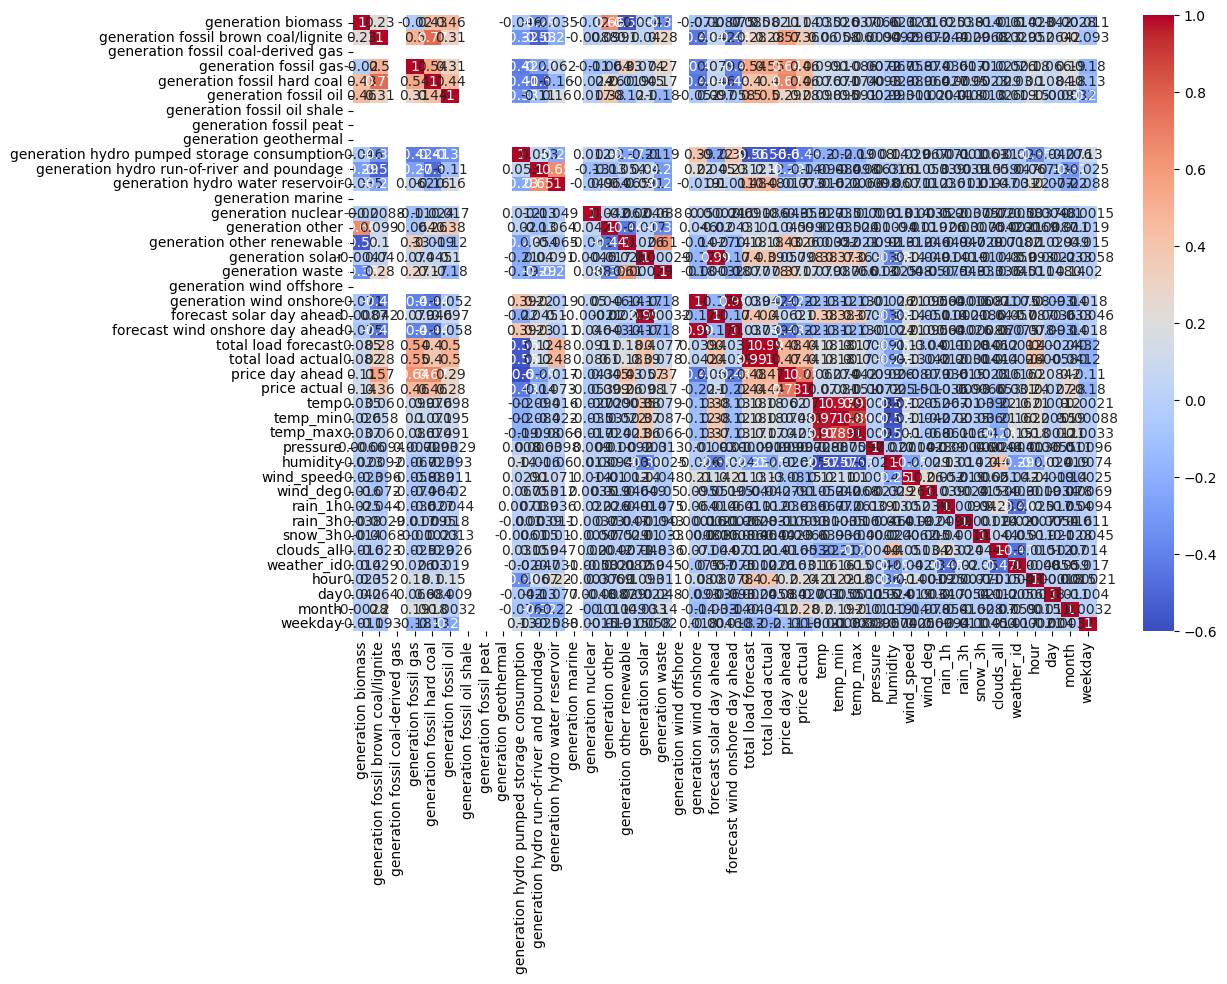

In [54]:
# Drop non-numeric columns
numerical_cols = data.select_dtypes(include=[np.number])

# Check for correlation between features
corr = numerical_cols.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

### **7.3 Time Series Visualization**

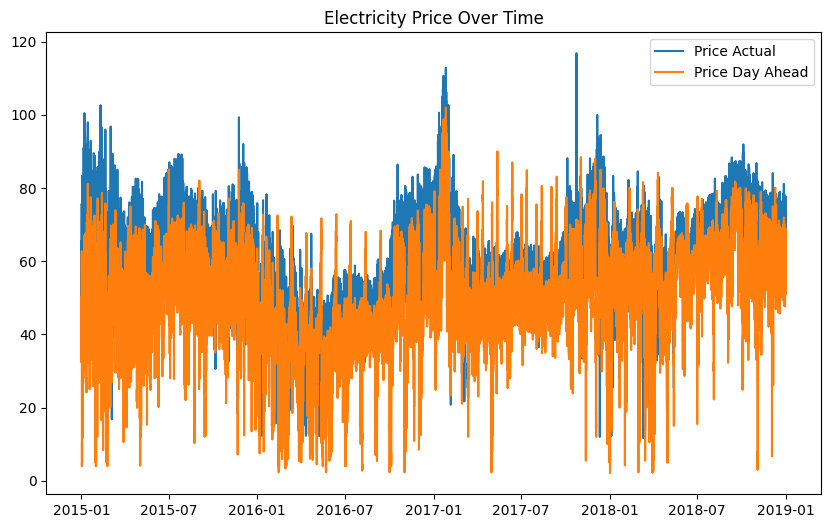

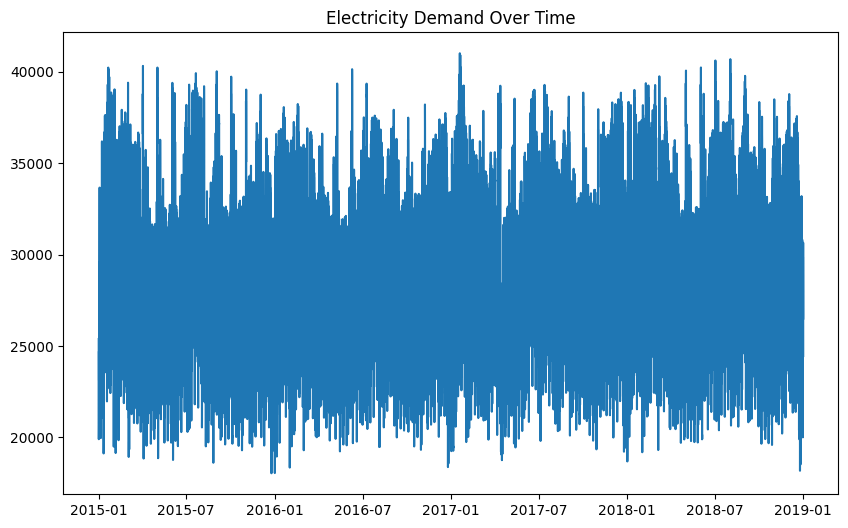

In [55]:
# Time series plots of electricity price and demand over time
plt.figure(figsize=(10, 6))
plt.plot(data['time'], data['price actual'], label='Price Actual')
plt.plot(data['time'], data['price day ahead'], label='Price Day Ahead')
plt.legend()
plt.title('Electricity Price Over Time')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(data['time'], data['total load actual'], label='Total Load Actual')
plt.title('Electricity Demand Over Time')
plt.show()

## **8. Feature Engineering**

### **8.1 Create New Features**

In [39]:
# Extract useful time-based features
data['hour'] = data['time'].dt.hour
data['day'] = data['time'].dt.day
data['month'] = data['time'].dt.month
data['weekday'] = data['time'].dt.weekday

### **8.2 Select Relevant Features**

In [56]:
# Features for prediction
features = ['generation biomass', 'generation fossil gas', 'generation solar', 
            'generation wind onshore', 'total load actual', 'temp', 'pressure', 
            'humidity', 'wind_speed', 'hour', 'weekday']

X = data[features]
y_price = data['price actual']
y_load = data['total load actual']

## **9. Data Splitting and Scaling**

In [57]:
# Train-test split for price and load prediction
X_train, X_test, y_train_price, y_test_price = train_test_split(X, y_price, test_size=0.2, random_state=42)
X_train_load, X_test_load, y_train_load, y_test_load = train_test_split(X, y_load, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_load_scaled = scaler.fit_transform(X_train_load)
X_test_load_scaled = scaler.transform(X_test_load)

## **10. Model Building**

### **10.1 Random Forest Regressor**

In [58]:
# Random Forest for Price Prediction
rf_price = RandomForestRegressor(n_estimators=100, random_state=42)
rf_price.fit(X_train_scaled, y_train_price)

# Random Forest for Load Prediction
rf_load = RandomForestRegressor(n_estimators=100, random_state=42)
rf_load.fit(X_train_load_scaled, y_train_load)

RandomForestRegressor(random_state=42)

### **10.2 Gradient Boosting Regressor**

In [59]:
# Gradient Boosting for Price Prediction
gb_price = GradientBoostingRegressor(random_state=42)
gb_price.fit(X_train_scaled, y_train_price)

# Gradient Boosting for Load Prediction
gb_load = GradientBoostingRegressor(random_state=42)
gb_load.fit(X_train_load_scaled, y_train_load)

GradientBoostingRegressor(random_state=42)

### **10.3 Support Vector Regressor**

In [60]:
# Support Vector Regressor for Price Prediction
svr_price = SVR(kernel='rbf')
svr_price.fit(X_train_scaled, y_train_price)

# Support Vector Regressor for Load Prediction
svr_load = SVR(kernel='rbf')
svr_load.fit(X_train_load_scaled, y_train_load)

## **11 Model Evaluation**

### **11.1 Price Prediction Evaluation**

In [ ]:
# Predictions
y_pred_price_rf = rf_price.predict(X_test_scaled)
y_pred_price_gb = gb_price.predict(X_test_scaled)
y_pred_price_svr = svr_price.predict(X_test_scaled)

# Evaluation metrics
mse_rf_price = mean_squared_error(y_test_price, y_pred_price_rf)
r2_rf_price = r2_score(y_test_price, y_pred_price_rf)

mse_gb_price = mean_squared_error(y_test_price, y_pred_price_gb)
r2_gb_price = r2_score(y_test_price, y_pred_price_gb)

mse_svr_price = mean_squared_error(y_test_price, y_pred_price_svr)
r2_svr_price = r2_score(y_test_price, y_pred_price_svr)

# Display the results
print(f"Random Forest Price - MSE: {mse_rf_price}, R2: {r2_rf_price}")
print(f"Gradient Boosting Price - MSE: {mse_gb_price}, R2: {r2_gb_price}")
print(f"SVR Price - MSE: {mse_svr_price}, R2: {r2_svr_price}")

### **11.2 Load Prediction Evaluation**

In [ ]:
# Predictions
y_pred_load_rf = rf_load.predict(X_test_load_scaled)
y_pred_load_gb = gb_load.predict(X_test_load_scaled)
y_pred_load_svr = svr_load.predict(X_test_load_scaled)

# Evaluation metrics
mse_rf_load = mean_squared_error(y_test_load, y_pred_load_rf)
r2_rf_load = r2_score(y_test_load, y_pred_load_rf)

mse_gb_load = mean_squared_error(y_test_load, y_pred_load_gb)
r2_gb_load = r2_score(y_test_load, y_pred_load_gb)

mse_svr_load = mean_squared_error(y_test_load, y_pred_load_svr)
r2_svr_load = r2_score(y_test_load, y_pred_load_svr)

# Display the results
print(f"Random Forest Load - MSE: {mse_rf_load}, R2: {r2_rf_load}")
print(f"Gradient Boosting Load - MSE: {mse_gb_load}, R2: {r2_gb_load}")
print(f"SVR Load - MSE: {mse_svr_load}, R2: {r2_svr_load}")

## **12. Hyperparameter Tuning**

In [ ]:
# Hyperparameter tuning for Random Forest using GridSearchCV
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}

# GridSearch for price prediction
grid_rf_price = GridSearchCV(estimator=rf_price, param_grid=param_grid_rf, cv=5)
grid_rf_price.fit(X_train_scaled, y_train_price)

# GridSearch for load prediction
grid_rf_load = GridSearchCV(estimator=rf_load, param_grid=param_grid_rf, cv=5)
grid_rf_load.fit(X_train_load_scaled, y_train_load)

# Best parameters
print(grid_rf_price.best_params_)
print(grid_rf_load.best_params_)

## **10. Conclusion and Insights**

- **Performance Summary**: The Random Forest model performed with a mean squared error of **13.83** and an R-squared value of **0.93**. This indicates that the model can reasonably predict electricity prices based on past energy usage and weather data, although there may be room for improvement in predictive accuracy.

- **Key Insights from EDA**: Summarize any important relationships found during the exploratory data analysis.

- **Next Steps**: Suggest further improvements, such as trying other machine learning models, optimizing hyperparameters, or incorporating additional external datasets.